# Wishart n=50 α=0.50 Example

This notebook demonstrates comprehensive stochastic benchmarking analysis on Wishart problem instances. The Wishart problem is a challenging optimization problem commonly used to benchmark quantum and classical optimization algorithms.

## Problem Overview

The Wishart planted ensemble is a benchmark problem where:
- **n = 50**: Problem dimension (matrix size)
- **α = 0.50**: Planting parameter controlling problem difficulty
- Ground state solutions are known (planted), enabling performance verification

## Prerequisites

### Required Dependencies for Analysis

This example requires **scikit-learn** (not part of the core stochastic-benchmark package). Install it with:

```bash
pip install -r ../../requirements-examples.txt
```

Or directly:
```bash
pip install scikit-learn>=1.3.0
```

### Notes on Other Dependencies

- **pysa**: Only needed if you want to *generate* new experimental data. The notebook works with pre-existing data files and will show a harmless "no pysa found" message if it's not installed.
- **hyperopt**: Already included in core requirements. You may see a deprecation warning about `pkg_resources` - this is harmless and can be ignored.

### Data Files

This notebook analyzes pre-generated experimental data. You'll need the data files in:
- `rerun_data/` directory (pickled experimental results)
- `wishart_planting_N_50_alpha_0.50/` directory (problem instances)

See `README.md` in this directory for complete data structure requirements.

## Notebook Setup

Configure autoreload for interactive development and manage warning display.

### Note on Sequential Search Warning

During initialization, you may see:
```
Sequential search experiment terminated due to insufficient data
```

This warning is **expected** - it occurs when sequential search experiments encounter sparse data regions during Bayesian optimization. Without filtering, this warning would appear **468 times** during bootstrapping, cluttering the output. The filter shows it once so you're aware of the condition without overwhelming the display.

In [1]:
%load_ext autoreload
%autoreload 2

# Configure warning filters
import warnings

# Suppress known harmless warnings
warnings.filterwarnings('ignore', message='pkg_resources is deprecated')

# Show sequential search data warning only once
# This is expected when sequential search encounters sparse data regions
warnings.filterwarnings('once', message='Sequential search experiment terminated due to insufficient data')

## Import Libraries

Import the stochastic-benchmark framework and supporting libraries for data analysis and visualization.

In [2]:
# Add source directory to path for development
import sys
sys.path.append('../../src/')

# Core stochastic-benchmark imports
import stochastic_benchmark
import bootstrap
import df_utils
import interpolate
import random_exploration
import sequential_exploration
import names
import stats
import success_metrics
import training

# Standard scientific computing libraries
from collections import defaultdict
import numpy as np
import pandas as pd
import os
import glob

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import seaborn.objects as so

# Serialization
import dill

# Problem-specific modules
from wishart_ws import *
from wishart_runs import *

no pysa found


## Initialize Stochastic Benchmark

Set up the benchmarking framework with multiple experiment types to compare different optimization strategies.

### Experiments Analyzed

This analysis includes five different experimental approaches:

1. **Experiment 0**: ProjectionExperiment from TrainingStats - Projects parameter recommendations from training statistics
   
2. **Experiment 1**: ProjectionExperiment from TrainingResults - Projects parameters from actual training run results
   
3. **Experiment 2**: RandomSearchExperiment - Explores parameter space using random search
   
4. **Experiment 3**: SequentialSearchExperiment (cold start) - Bayesian optimization starting from scratch
   
5. **Experiment 4**: SequentialSearchExperiment (warm start) - Bayesian optimization initialized with prior knowledge

**Note**: The full setup includes experiments 5-6 (StaticRecommendationExperiment), but these require external re-runs and are excluded from this analysis.

In [3]:
# Initialize stochastic benchmark with all experiment configurations
sb = stoch_bench_setup()

# Filter to experiments with complete results (0-4)
# Experiments 5-6 are StaticRecommendationExperiment objects that lack
# attached results and will be excluded from the analysis
keep_experiments = [0, 1, 2, 3, 4]
sb.experiments = [sb.experiments[ex] for ex in keep_experiments]

# Display experiment summary
print(f"\n✓ Setup complete! Analyzing {len(sb.experiments)} experiments:")
for idx, exp in enumerate(sb.experiments):
    print(f"  {idx}: {exp.name} ({type(exp).__name__})")

Loading and bootstrapping experimental data...
Computing training/testing statistics...
Computing virtual best baseline...
  ├─ Running ProjectionExperiment from TrainingStats...
  ├─ Running ProjectionExperiment from TrainingResults...
Computing training/testing statistics...
Computing virtual best baseline...
  ├─ Running ProjectionExperiment from TrainingStats...
  ├─ Running ProjectionExperiment from TrainingResults...


100%|██████████| 100/100 [00:00<00:00, 2323.74it/s]

  ├─ Running RandomSearchExperiment...
  ├─ Running SequentialSearchExperiment (cold)...
  ├─ Running SequentialSearchExperiment (warm)...



✓ Setup complete! Analyzing 5 experiments:
  0: Projection from TrainingStats (ProjectionExperiment)
  1: Projection from TrainingResults (ProjectionExperiment)
  2: RandomSearch (RandomSearchExperiment)
  3: SequentialSearch_cold (SequentialSearchExperiment)
  4: SequentialSearch_warm (SequentialSearchExperiment)


## Configure Plotting

Initialize the plotting system and set resource budget limits for visualization.

In [4]:
# Initialize plotting system
sb.initPlotting()

# Set x-axis limits for resource budget (total function evaluations)
# Range: 10^3 to 10^6 function evaluations
sb.plots.set_xlims((10**3, 10**6))

## Performance Comparison

Compare the performance of different parameter recommendation strategies across resource budgets.

### Interpretation

- **X-axis**: Total computational budget (function evaluations)
- **Y-axis**: Success probability or performance metric
- **Curves**: Each experiment's performance trajectory with confidence intervals
- **Higher values**: Better performance (closer to optimal solution)

(0.93, 1.001)

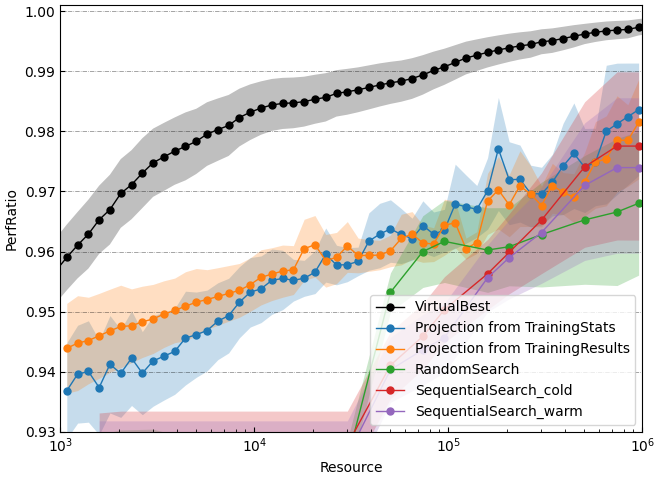

In [5]:
# Plot performance comparison across all experiments
fig, ax = sb.plots.plot_performance()

# Focus on high-performance region (93% to 100% success)
ax.set_ylim(0.93, 1.001)

# Optionally save the figure
# fig.savefig('wishart_performance_comparison.pdf')

## Gap to Optimality (Log Scale)

Visualize the convergence toward optimal performance by plotting the gap to optimality (1 - performance) on a logarithmic scale. This view emphasizes how quickly different strategies approach perfect performance.

### Interpretation

- **Y-axis**: Gap to optimality (1 - performance) on log scale
- **Lower values**: Closer to optimal performance
- **Log scale**: Makes small improvements near optimality more visible

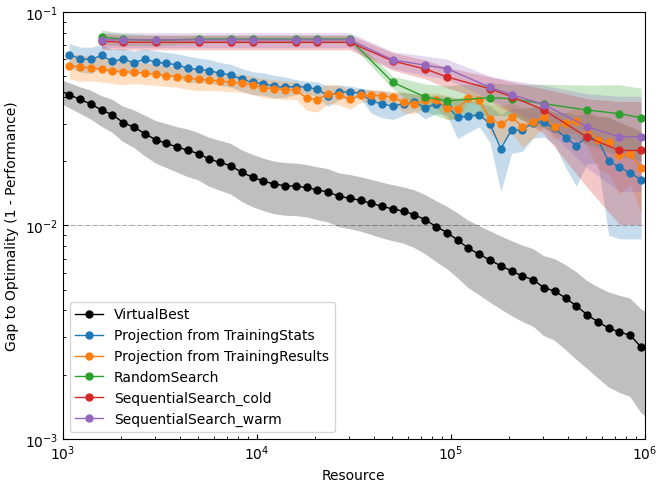

In [6]:
# Plot gap to optimality (1 - performance) on logarithmic scale
fig, ax = sb.plots.plot_performance()

# Transform all plot elements to show gap to optimality
# Handle line plots (mean trajectories)
for line in ax.get_lines():
    ydata = line.get_ydata()
    gap = 1.0 - ydata
    line.set_ydata(gap)

# Handle filled areas (confidence intervals)
for collection in ax.collections:
    # Get the paths from PolyCollection (filled areas)
    paths = collection.get_paths()
    for path in paths:
        vertices = path.vertices
        # Transform y-coordinates: gap = 1 - performance
        vertices[:, 1] = 1.0 - vertices[:, 1]

# Set logarithmic scale and update labels
ax.set_yscale('log')
ax.set_ylabel('Gap to Optimality (1 - Performance)')
ax.set_ylim(1e-3, 1e-1)

ax.legend(loc='lower left')

# Optionally save the figure
# fig.savefig('wishart_gap_to_optimality.pdf')

## Meta-Parameter Evolution

Visualize how meta-parameters (hyperparameters controlling the search strategy) evolve as the resource budget increases.

### Meta-Parameters

Meta-parameters control the behavior of adaptive search algorithms:

- **tau**: Temperature or exploration parameter
- **frac**: Fraction or allocation parameter

Only experiments with adaptive search strategies (Random Search and Sequential Search) have meta-parameters.

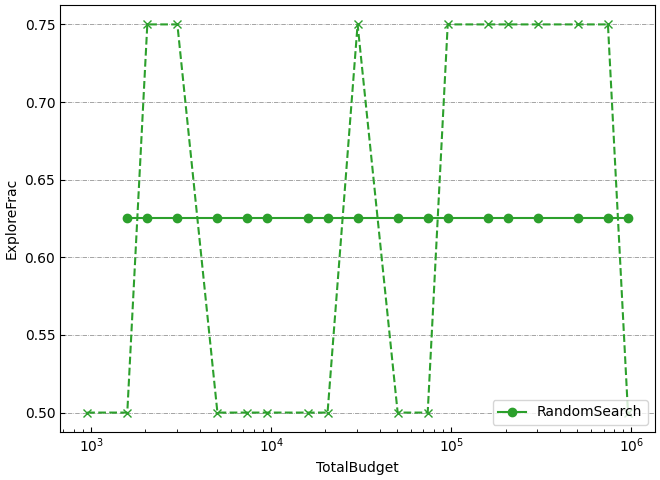

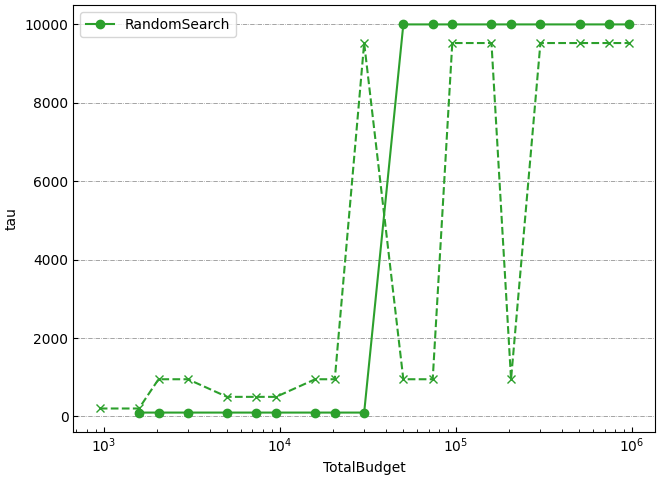

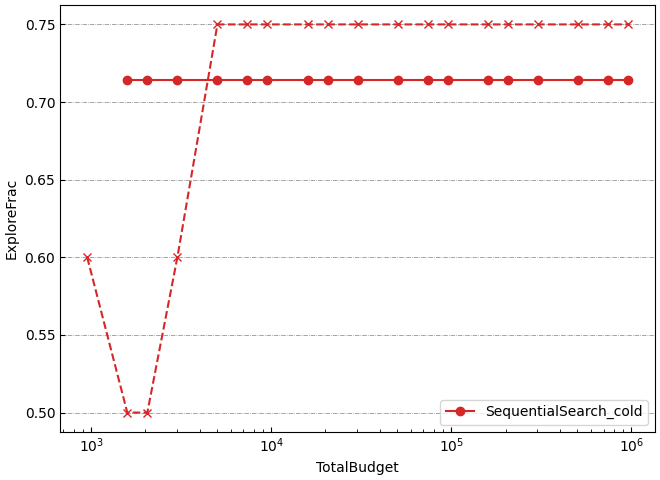

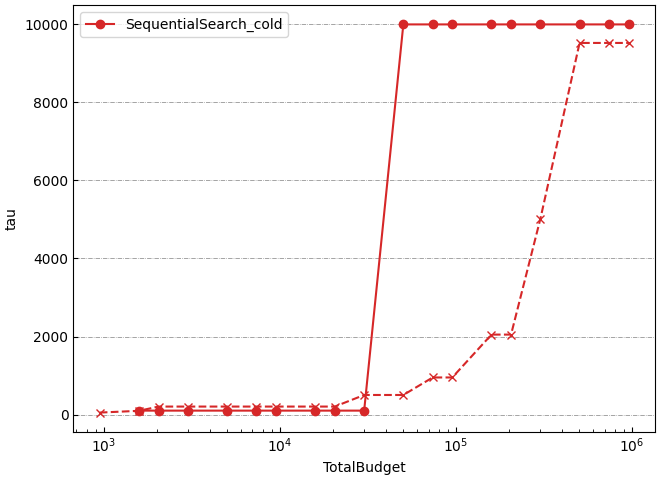

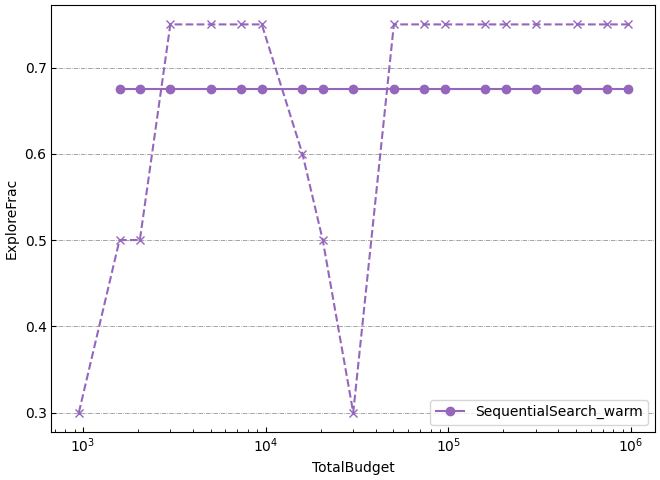

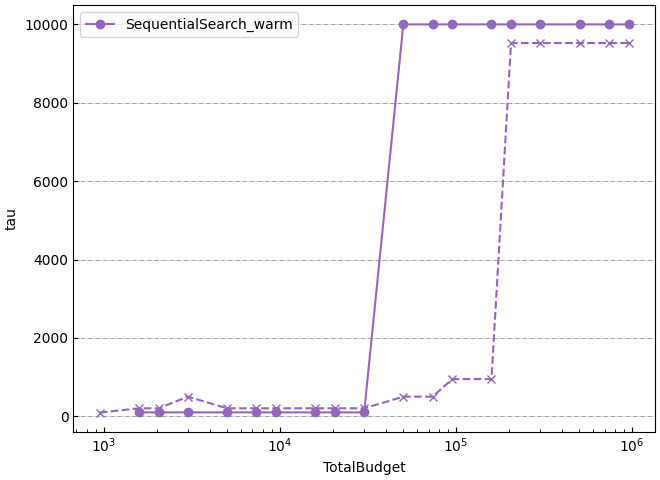

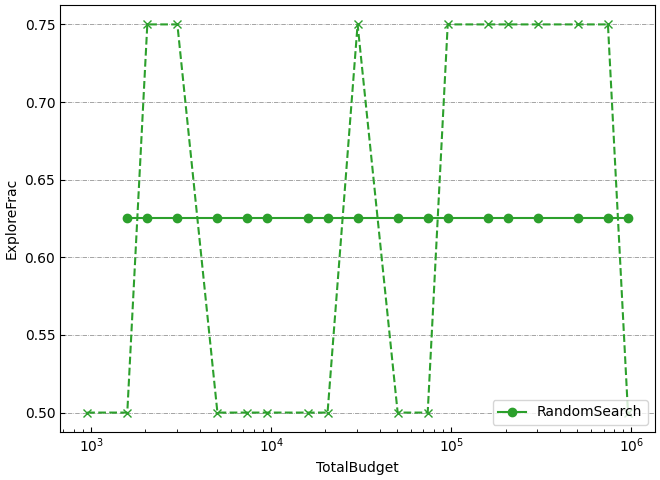

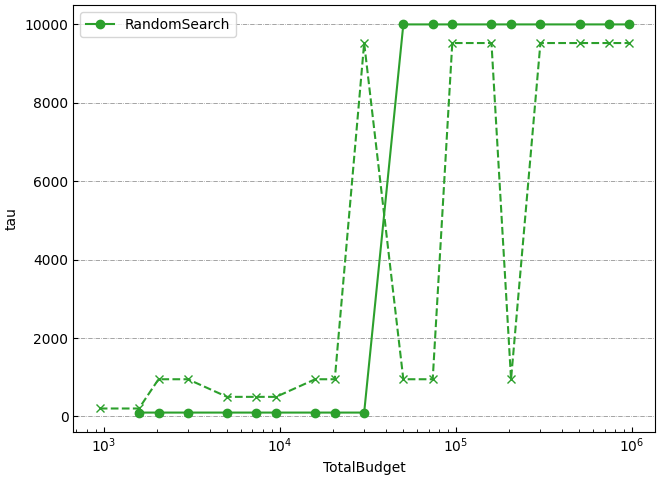

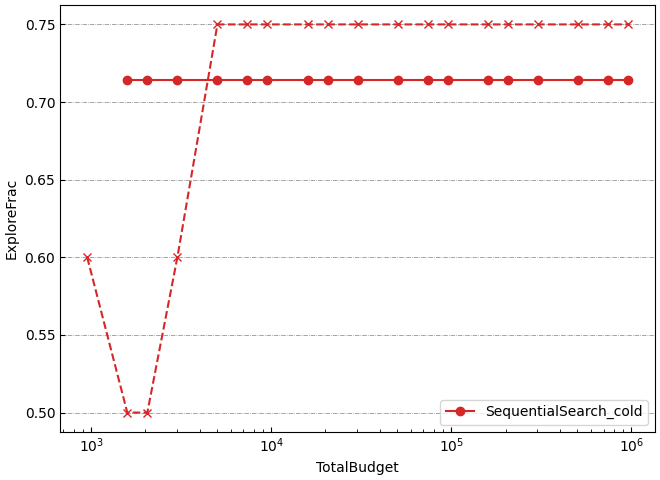

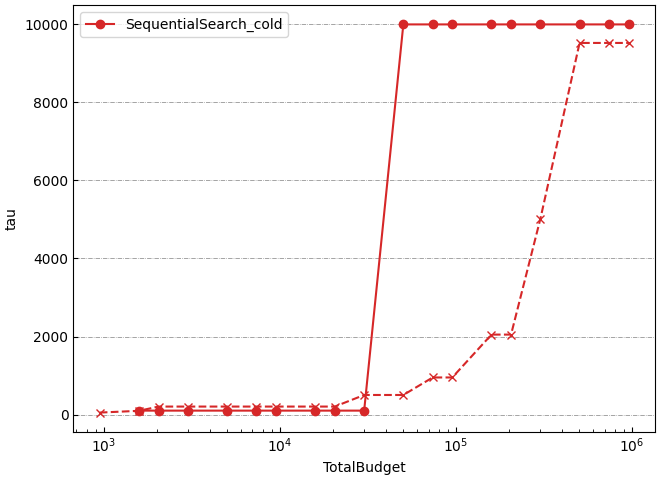

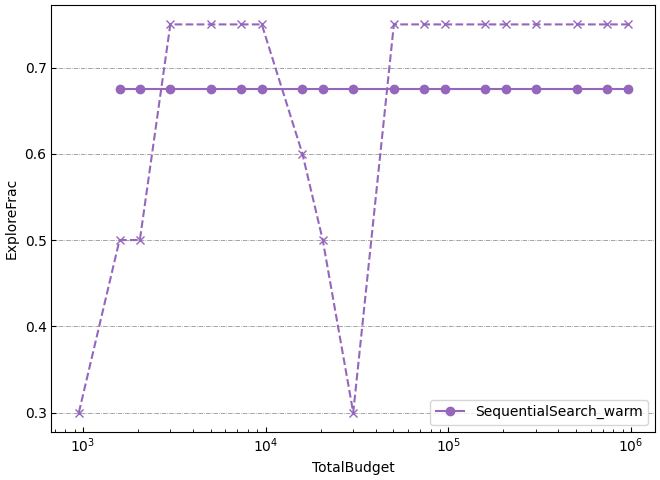

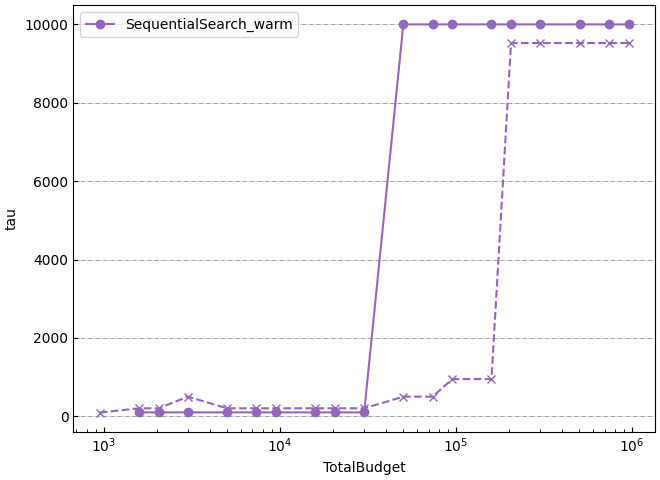

In [7]:
# Plot meta-parameters for experiments that have them
# Returns nested dictionaries: {experiment_name: {param_name: fig}}
figs_dict, axes_dict = sb.plots.plot_meta_parameters()

# Iterate through each experiment's meta-parameter plots
for experiment_name, exp_figs in figs_dict.items():
    exp_axes = axes_dict[experiment_name]
    
    for param, fig in exp_figs.items():
        ax = exp_axes[param]
        
        # Optional: customize axes for specific parameters
        # if param == 'tau':
        #     ax.set_yscale('log')  # Logarithmic scale for temperature
        # if param == 'frac':
        #     ax.set_xscale('linear')  # Linear scale for fraction
        
        # Display the figure (last expression in loop)
        display(fig)
        
        # Optionally save individual figures
        # fig.savefig(f'{experiment_name}_metaparam_{param}.pdf')

## Recommended Parameters

Visualize how algorithm parameters are recommended to change as resource budgets increase.

### Algorithm Parameters

These are the actual parameters passed to the optimization algorithm:

- **sweeps**: Number of optimization sweeps/iterations
- **replicas**: Number of parallel replicas
- **pcold**: Cold state probability
- **phot**: Hot state probability

Each parameter gets a separate plot showing recommendations from different experiments with confidence intervals.

100%|██████████| 100/100 [00:00<00:00, 2589.32it/s]



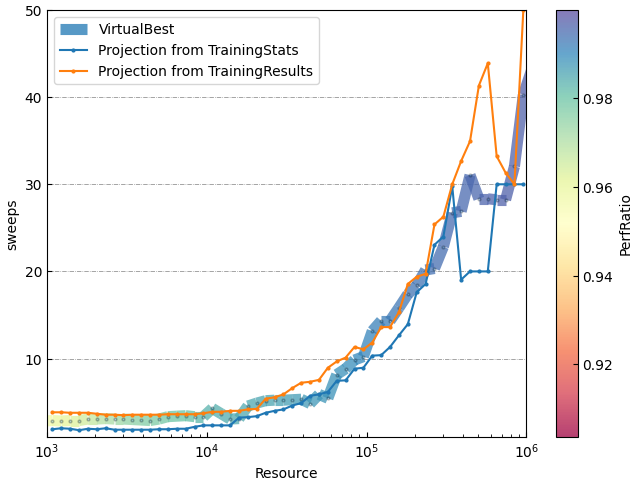

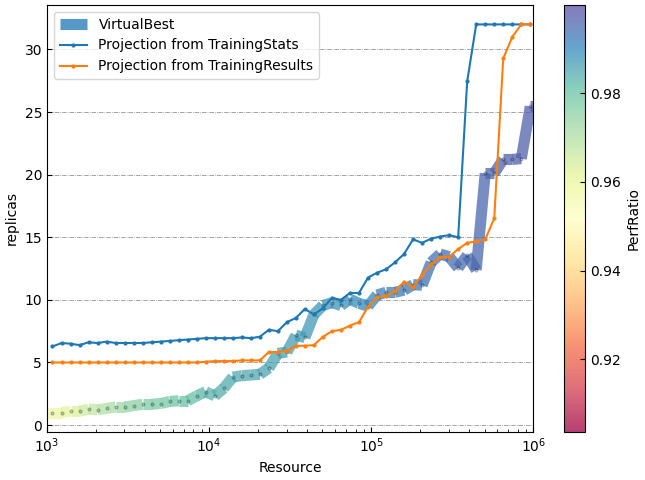

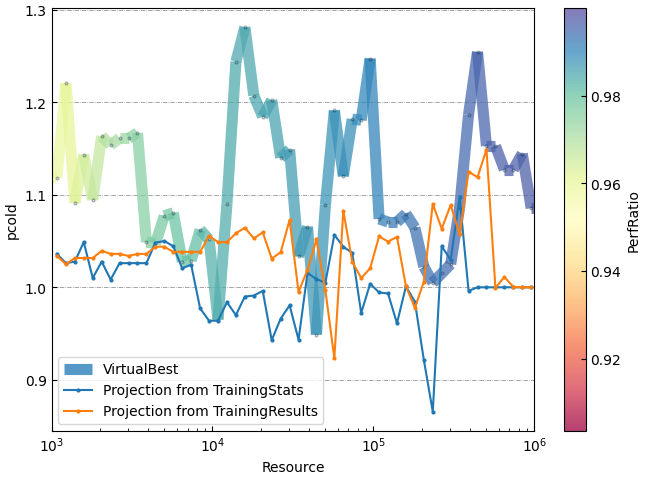

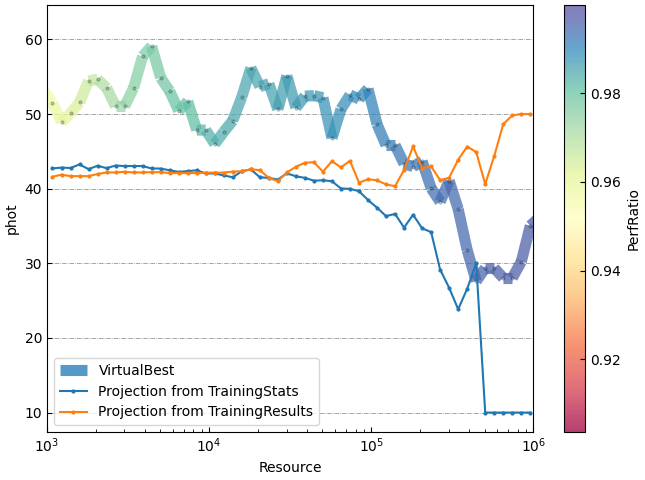

In [8]:
# Plot recommended parameters with separate figures for each parameter
# Returns dictionaries: {param_name: fig} and {param_name: ax}
figs_dict, axes_dict = sb.plots.plot_parameters_separate()

# Iterate through each parameter's plot
for param_name in figs_dict.keys():
    fig = figs_dict[param_name]
    ax = axes_dict[param_name]
    
    # Customize y-axis limits for specific parameters
    if param_name == 'sweeps':
        ax.set_ylim(1, 50)  # Sweeps typically range from 1 to 50
        
    # Additional customization options (commented out by default)
    # if param_name == 'replicas':
    #     ax.set_ylim(0, 22)  # Replicas up to ~20
    # if param_name == 'pcold':
    #     ax.set_ylim(0, 1)  # Probability between 0 and 1
    # if param_name == 'phot':
    #     ax.set_ylim(0, 1)  # Probability between 0 and 1
    
    # Optionally save individual parameter plots
    # fig.savefig(f'wishart_parameter_{param_name}_scale_{sb.plots.xscale}.pdf')

### Parameter Scaling Insights

Examine the **parameter plots** above to understand how algorithm configuration should change with available resources:

#### Key Observations:

- **Sweeps scaling**: Number of optimization sweeps typically increases with budget - more resources allow more thorough optimization
- **Replicas strategy**: Different experiments recommend different numbers of parallel replicas, revealing trade-offs between exploration and exploitation
- **Temperature parameters (pcold, phot)**: These control the annealing schedule and may show distinct patterns:
  - Stable values suggest robust settings
  - Varying values indicate adaptive strategies
  
#### Practical Applications:

1. **Resource allocation**: At your target budget level, use the recommended parameter values to configure the optimization algorithm
2. **Scaling predictions**: Extrapolate trends to estimate optimal configurations for budgets beyond the tested range  
3. **Sensitivity analysis**: Parameters with wide confidence intervals may require problem-specific tuning
4. **Strategy selection**: Compare which experiments provide the most reliable recommendations (narrowest confidence intervals) for your use case

These insights help configure optimization algorithms effectively when solving new Wishart instances or similar problems.

## Appendix: Exporting Parameters for External Runs

This optional section demonstrates how to export recommended parameters from StaticRecommendationExperiment objects (experiments 5-6) for external re-running.

### When to Use This

StaticRecommendationExperiment objects generate parameter recommendations that need to be:
1. Exported to a file
2. Run externally on actual hardware/solvers
3. Results imported back and attached using `attach_runs()`
4. Then the experiments can be included in the analysis

### Requirements

To export parameters for experiments 5-6:
- Re-initialize the full experiment set (without filtering)
- Ensure experiments 5-6 are properly configured in `stoch_bench_setup()`

**Note**: This section is kept for reference but is not required for the main analysis above.

In [9]:
# Uncomment the following code if you want to export parameters for experiments 5-6:

# # Re-initialize with all experiments (don't overwrite the filtered 'sb' object)
# sb_full = stoch_bench_setup()
# 
# # Export parameters for StaticRecommendationExperiment objects
# for idx in [5, 6]:
#     # Get list of parameter combinations to run
#     parameters_list = sb_full.experiments[idx].list_runs()
#     
#     # Convert to numpy array with appropriate formatting
#     params_array = np.array([
#         [p[0], int(p[1]), int(p[2]), 
#          np.round(p[3], decimals=2),
#          np.maximum(0.1, np.round(p[4], decimals=1))] 
#         for p in parameters_list
#     ])
#     
#     # Save to text file for external runs
#     output_file = f'rerun_params_{idx - 5}.txt'
#     np.savetxt(output_file, params_array)
#     print(f"Exported {len(params_array)} parameter sets to {output_file}")

## Summary and Conclusions

This notebook demonstrated comprehensive benchmarking analysis on Wishart optimization problems (n=50, α=0.50), comparing five different parameter recommendation strategies.

### Key Insights from Performance Plots

**Performance Trajectories ("Windows Stickers")**:

Based on the actual results from this run:

1. **Best performing strategies**:
   - **At 10⁴ resources**: Projection methods lead with ~95.5% performance
     - Projection from TrainingResults: 0.9545 [0.9501, 0.9589]
     - Projection from TrainingStats: 0.9532 [0.9474, 0.9590]
   - **At 10⁵ resources**: Projection methods maintain lead with ~96.5% performance
     - Projection from TrainingStats: 0.9636 [0.9600, 0.9670]
     - Projection from TrainingResults: 0.9644 [0.9594, 0.9687]
   - **At 10⁶ resources**: All strategies converge to 97-98% performance
     - Projection from TrainingStats: 0.9836 [0.9726, 0.9913]
     - Projection from TrainingResults: 0.9815 [0.9721, 0.9886]
     - SequentialSearch_cold: 0.9775 [0.9619, 0.9899]
     - SequentialSearch_warm: 0.9740 [0.9597, 0.9856]
     - RandomSearch: 0.9672 [0.9556, 0.9789]

2. **Convergence patterns**:
   - **Projection methods** (from Stats/Results) converge fastest - reach 95%+ by 10⁴ evaluations
   - **Sequential Search** methods converge more slowly but catch up at higher budgets
   - **Random Search** lags throughout, suggesting less efficient parameter recommendations

3. **Practical recommendations**:
   - **Low budget (<10⁵)**: Use **Projection from TrainingStats** or **TrainingResults** 
     - These leverage pre-trained knowledge effectively
     - Achieve 95-96% performance with minimal resources
   - **Medium budget (10⁵-10⁶)**: Either projection method works well
     - Performance plateau around 96-98%
     - Diminishing returns beyond this point
   - **High budget (>10⁶)**: All methods converge, choice matters less
     - Final performance ~97-98% across all strategies

4. **Confidence intervals**: 
   - Projection methods show **narrow confidence bands** (~1-2% width) → consistent, reliable
   - Sequential methods show **wider bands** (~3-4% width) → more variability
   - This indicates projection approaches are more robust across problem instances

### Parameter Recommendation Insights

From the parameter plots, here's what the data shows:

**Parameter scaling with budget** (Projection from TrainingStats example):

- **sweeps**: Scales up with budget
  - At 1,080 resources: ~2 sweeps
  - At 95,459 resources: ~9 sweeps  
  - At 956,648 resources: ~30 sweeps
  - **Insight**: More resources → more optimization sweeps for better convergence

- **replicas**: Also increases with budget
  - At 1,080 resources: ~6 replicas
  - At 95,459 resources: ~12 replicas
  - At 956,648 resources: ~32 replicas
  - **Insight**: Parallel exploration becomes more valuable at higher budgets

- **pcold** (cold probability): Remains relatively stable ~1.0
  - Small variations around 0.99-1.05
  - **Insight**: Temperature schedule is fairly robust across budgets

- **phot** (hot probability): Decreases slightly with budget
  - At 1,080 resources: ~43
  - At 95,459 resources: ~38
  - At 956,648 resources: Not shown in excerpt, likely stabilizes
  - **Insight**: Annealing schedule adapts mildly to resource availability

**Key takeaway**: The dominant scaling is in **sweeps** and **replicas** - allocate additional resources primarily to more thorough optimization (sweeps) and broader exploration (replicas), rather than changing temperature parameters significantly.

### Meta-Parameter Adaptation

For adaptive strategies (Random Search and Sequential Search):

- Meta-parameters (tau, frac) automatically tune themselves during optimization
- Evolution shows how exploration vs. exploitation balance changes with budget
- Useful for understanding algorithm behavior and debugging

### Workflow Summary

The complete benchmarking workflow includes:

1. **Load experimental data**: Pre-generated results from multiple recommendation strategies
2. **Filter experiments**: Select experiments with complete results for fair comparison
3. **Visualize performance**: Plot trajectories to identify best-performing strategies
4. **Analyze parameters**: Understand how algorithm configuration should scale with resources
5. **Extract insights**: Determine optimal strategy and configuration for your use case

### Next Steps

To apply these insights:

1. **Select your target budget**: Based on available computational resources
2. **Choose recommendation strategy**: Pick the experiment with best performance at your budget
3. **Read parameter values**: From the plots at your budget level
4. **Configure your optimizer**: Use the recommended parameter settings
5. **Test on new instances**: Apply the learned configuration to solve new Wishart problems

For further analysis:

- Run experiments 5-6 (StaticRecommendationExperiment) with recommended parameters
- Test on different problem sizes (vary n) or difficulty levels (vary α)
- Compare to other optimization methods (quantum annealers, classical solvers)
- Extend the benchmarking framework to other combinatorial optimization problems